# Урок 5. Случайный лес

### Изменения были в:
    
- генерации данных (100 объектов с двумя признаками, также убрала random state)
- функция get_bootstrap - добавила вывод использованных в каждом дереве индексов
- функция random_forest - добавила прием и вывод использованных индексов
- фукнция tree_vote - добавление расчета OOB
- функция gini переписана в функцию calc_entropy

In [41]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [104]:
# сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1)

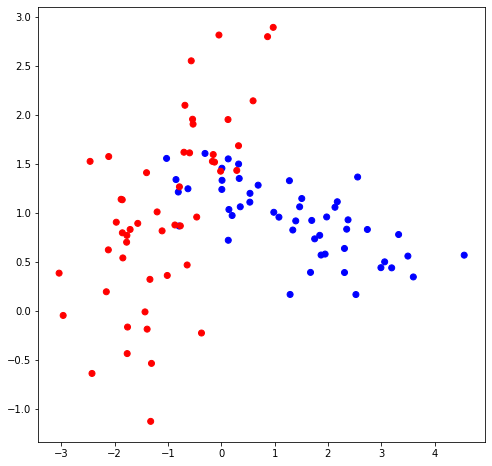

In [105]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [106]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = [] # новая бутстреп выборка
    for i in range(N): # цикл по кол-ву деревьев
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        indexes = []
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1) # выбираем индекс нового объекта бутстреп выборки
            b_data[j] = data[sample_index] 
            b_labels[j] = labels[sample_index]
            indexes.append(sample_index)
        bootstrap.append((b_data, b_labels, indexes)) # ДОБАВИЛА ВЫВОД ИНДЕКСОВ
    return bootstrap

In [107]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes) # перемешаем индексы
    subsample = sample_indexes[0:len_subsample].copy() # возьмем первые len_subsample
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    #print(f'subsample = {subsample}')
    return subsample

In [108]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [109]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [110]:
# Расчет критерия Шеннона
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** np.log2(p)
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
# !!! ИЗМЕНЕНИЯ !!! 
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = calc_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample: # выбираем из подпространства признаков, для каждого нового разбиения будет новое подпространство 
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [111]:
def random_forest(data, labels, n_trees):  # ДОБАВИЛА ВЫВОД ИНДЕКСОВ
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    indexes_forest = []
    for b_data, b_labels, indexes in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
        indexes_forest.append(indexes)
    return forest, indexes_forest

In [112]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)  
    
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, used_indexes, data, true_prediction):  # ИЗМЕНЕНИЕ ПО ДОМАШНЕМУ ЗАДАНИЮ. ДОБАВЛЕНИЕ РАСЧЕТА OOB

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # голосование большинства
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    # Вариант1   
    # Реализация предсказания каждого дерева на полный массив неиспользованных индексов. 
    # Предсказания получила. Можно сделать словарь по индексам и голосовать, пробегаясь по словарю.
    # predictions_OOB = []
    # for check_pack in range(len(used_indexes)):
    #    non_used_indexes = [i for i in range(len(data)) if i not in used_indexes[check_pack]]
    #    print(data[non_used_indexes], forest[check_pack])
    #    predictions_OOB.append(predict(data[non_used_indexes], forest[check_pack]))
    #    print(predictions_OOB)
    
    # Вариант2 (реализованный). Пробегаться сразу по индексам и проверять наличие этого индекса в списках использованных.
    # Если нет, голосовать и записывать предикт. На месте же голосовать и выдавать prediction. Сразу же сравнивать 
    # с реальным значением. Увеличивать ошибку в случае неверных голосов.
    count_used_indexes = 0
    false_prediction = 0
    
    for index in range(len(data)):  # пробегаемся по каждому объекту
        index_prediction = []
        for i in range(len(used_indexes)):  # пробегаемся по каждому дереву/использованным идексам
            if index not in used_indexes[i]: # если индекс не использовался, то считаем предикт
                # print(predict([data[i]], forest[i]))
                index_prediction.append(*predict([data[i]], forest[i]))
        if len(index_prediction) > 0: # Если были голосования, то проверяем верно ли проголосовали деревья
            if max(set(index_prediction), key=index_prediction.count) != true_prediction[index]:
                false_prediction += 1    # если неверно - увеличиваем ошибку
            count_used_indexes += 1      # счетчик всех использованных (count - false = true)
#    print(false_prediction, count_used_indexes)
    OOB = false_prediction / count_used_indexes
                  
    return round(OOB, 2), voted_predictions 

In [143]:
n_trees = 50

my_forest_50 = random_forest(classification_data, classification_labels, n_trees) # обучение на всей выборке (с использованием бутстрэп)

OOB, answers = tree_vote(my_forest_50[0], my_forest_50[1], classification_data, classification_labels) # my_forest_1[0] - деревья, 
# [1] - индексы, которые участвовали в каждом дереве

print(f'Относительная величина ошибки "мини леса" на объектах, на которых он не обучался, составила {OOB}')

Относительная величина ошибки "мини леса" на объектах, на которых он не обучался, составила 0.46


Чем меньше эта величина, тем лучше.

In [114]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Ошибка полученных ответов с использованием голосования всех деревьев:

In [144]:
accuracy = accuracy_metric(classification_labels, answers)
accuracy

93.0